In [2]:
# Importing the necessary modules, libraries and dependencies

from collections import Counter # For storing elements as dictionary keys, and their counts stored as dictionary values
import numpy as np  # linear algebra
import pandas as pd  # data processing
from keras.models import Sequential # Importing sequential model from Keras for multi-label classification
from keras.layers import Dense, Flatten, BatchNormalization # List of layers that will be passed to the sequential constructor
from keras.optimizers import Adam # Msking use of Adam optimizer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # Set of functions to be applied at given stages of the training procedure
from keras.applications.vgg19 import VGG19 # Importing VGG19 as base model
import cv2 # To integrate OpenCV arrays with other libraries which use NumPy
from tqdm import tqdm # For iterations
from sklearn.model_selection import KFold # To randomly divide the dataset into k groups or folds of approximately equal size
from sklearn.metrics import fbeta_score # Weighted harmonic mean of precision and recall between 0 and 1
import plotly.graph_objs as go # For graphs and plots
import plotly.offline as py # To generate graphs as images
py.init_notebook_mode(connected=True) # To view the graphs on notebooks
import matplotlib.pyplot as plt # Module pyplot
%matplotlib inline

# Planet: Understanding the Amazon from Space
### Use satellite data to track the human footprint in the Amazon rainforest

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.

In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.

### Nikitarom's Planet dataset was added for this project to be executed.
The dataset consists of the required training images, test images, additional test images, train csv and sample submission csv.

The train and sample submission csv files contain image names with their respective tags.
The training images are 40479 jpg files to be used for training and validating the model.
The test images and additional test files 40669 and 20522 jpg files respectively for testing the model. A total of 61191 jpg files for testing the model.

In [3]:
# Setting hyper-parameters for training, validation and testing
input_size = 128
input_channels = 3
epochs = 5
batch_size = 128
n_folds = 2
training = True
ensemble_voting = False

In [4]:
# Loading the train data
df_train_data = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')

# Previewing the first five rows
df_train_data.head(5)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
# Loading the test data
df_test_data = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

# Previewing the first five rows
df_test_data.head(5)

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [6]:
# Exploratory Data Analysis
# Bar-plot
labels = df_train_data['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=800, width=800, title='Distribution of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-label-dist')

In [7]:
# Heatmap
htmp = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        htmp[i, i2] = cy / c

data=[go.Heatmap(z=htmp, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Heatmap of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-htmp')

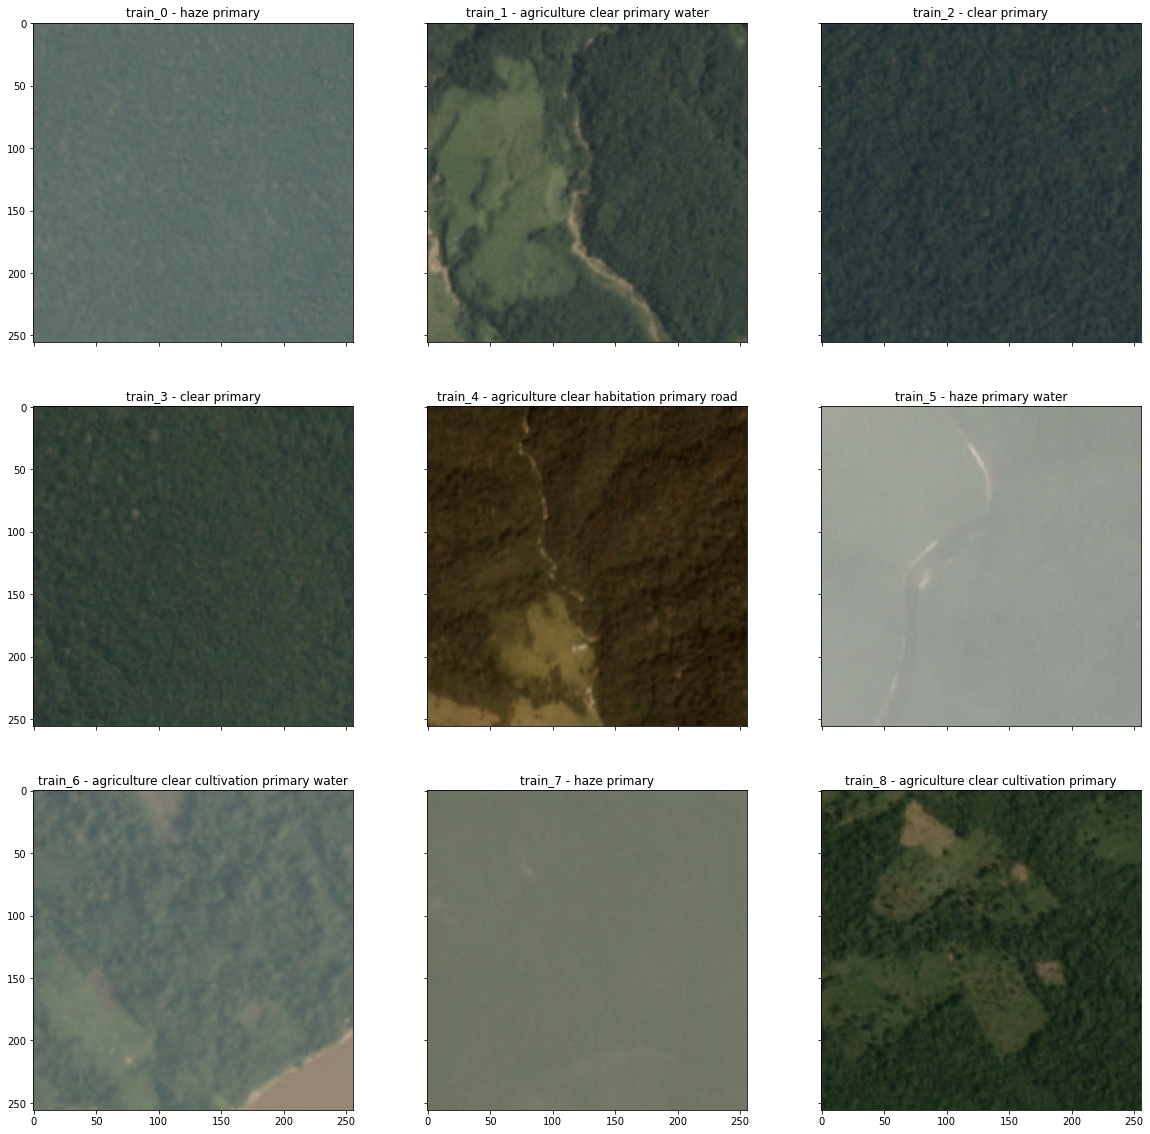

In [8]:
# Preview some images with their respective tags
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train_data[:9].values:
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

In [9]:
# Setting the dataframe for both test data in different paths
df_test1 = df_test_data.iloc[:40669]
df_test2 = df_test_data.iloc[40669:]

In [10]:
# Obtaining unique labels from the training data
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train_data['tags'].values])))
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [11]:
# Instantiating kfold - To randomly divide the dataset into k groups or folds of approximately equal size
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
fold_count = 0

# Setting empty list for testing
y_full_test1 = []
y_full_test2 = []

# Setting a threshold
thres_sum = np.zeros(17, np.float32)

In [12]:
# A 'for' loop that will train and test the data in n_folds number of times
for train_index, test_index in kf.split(df_train_data):

    # To iterate
    fold_count += 1
    print('Fold ', fold_count)
    
    # First function: For image transformation
    def transformations(src, choice):
        if choice == 0:
            # Rotate 90
            src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotate 90 and flip horizontally
            src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            src = cv2.flip(src, flipCode=1)
        if choice == 2:
            # Rotate 180
            src = cv2.rotate(src, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotate 180 and flip horizontally
            src = cv2.rotate(src, rotateCode=cv2.ROTATE_180)
            src = cv2.flip(src, flipCode=1)
        if choice == 4:
            # Rotate 90 counter-clockwise
            src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotate 90 counter-clockwise and flip horizontally
            src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            src = cv2.flip(src, flipCode=1)
        return src
    
    # Number of samples to train
    df_valid = df_train_data.iloc[test_index]
    print('Validating on {} samples'.format(len(df_valid)))
    
    # Second function: To obtain validation data from the training images
    def valid_generator():
        while True:
            for start in range(0, len(df_valid), batch_size):
                x_batch = []
                y_batch = []
                end = min(start + batch_size, len(df_valid))
                df_valid_batch = df_valid[start:end]
                for f, tags in df_valid_batch.values:
                    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f)) # Loading the images from the specified files
                    img = cv2.resize(img, (input_size, input_size)) # Resizing the images
                    img = transformations(img, np.random.randint(6)) # Calling the transformation function
                    targets = np.zeros(17)
                    # Splitting and appending respective tags
                    for t in tags.split(' '):
                        targets[label_map[t]] = 1
                    x_batch.append(img)
                    y_batch.append(targets)
                # Converting both list to NumPy array
                x_batch = np.array(x_batch, np.float32)
                y_batch = np.array(y_batch, np.uint8)
                yield x_batch, y_batch

    # Number of samples to train
    df_train = df_train_data.iloc[train_index]
    if training:
        print('Training on {} samples'.format(len(df_train)))

    # Third function: To obtain training data from the training images
    def train_generator():
        while True:
            for start in range(0, len(df_train), batch_size):
                x_batch = []
                y_batch = []
                end = min(start + batch_size, len(df_train))
                df_train_batch = df_train[start:end]
                for f, tags in df_train_batch.values:
                    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f)) # Loading the images from the specified files
                    img = cv2.resize(img, (input_size, input_size)) # Resizing the images
                    img = transformations(img, np.random.randint(6)) # Calling the transformation function
                    targets = np.zeros(17)
                    # Splitting and appending respective tags
                    for t in tags.split(' '):
                        targets[label_map[t]] = 1
                    x_batch.append(img)
                    y_batch.append(targets)
                # Converting both lists to NumPy array
                x_batch = np.array(x_batch, np.float32)
                y_batch = np.array(y_batch, np.uint8)
                yield x_batch, y_batch

    # Instantiating VGG19 with hyper-parameters that have been set
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(input_size, input_size, input_channels))
    # Instantiating Sequential model
    model = Sequential()
    # Batchnorm input on the Sequential model
    model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))
    # Adiing the VGG19 to the Sequential model
    model.add(base_model)
    # To classify
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    # Setting the optimizer
    opt = Adam(lr=1e-4)
    # Compiling
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor='val_loss',
                               patience=4,
                               verbose=1,
                               min_delta=1e-4),
                 ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1),
                 ModelCheckpoint(filepath='weights/best_weights.fold_' + str(fold_count) + '.hdf5',
                                 save_best_only=True,
                                 save_weights_only=True)]
    # Fitting the model
    if training:
        model.fit_generator(generator=train_generator(),
                            steps_per_epoch=(len(df_train) // batch_size) + 1,
                            epochs=epochs,
                            verbose=2,
                            callbacks=callbacks,
                            validation_data=valid_generator(),
                            validation_steps=(len(df_valid) // batch_size) + 1)

    # Fourth funtion: Setting a threshold
    def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
        def mf(x):
            p2 = np.zeros_like(p)
            for i in range(17):
                p2[:, i] = (p[:, i] > x[i]).astype(np.int)
            score = fbeta_score(y, p2, beta=2, average='samples')
            return score
        # For each 17 tags
        x = [0.2] * 17
        for i in range(17):
            best_i2 = 0
            best_score = 0
            for i2 in range(resolution):
                i2 /= float(resolution)
                x[i] = i2
                score = mf(x)
                if score > best_score:
                    best_i2 = i2
                    best_score = score
            x[i] = best_i2
            if verbose:
                print(i, best_i2, best_score)
        return x

    # Obtaining the model's predictions
    p_valid = model.predict_generator(generator=valid_generator(), steps=(len(df_valid) // batch_size) + 1)
    # Empty list for valid data
    y_valid = []
    for f, tags in df_valid.values:
        targets = np.zeros(17)
        # Splitting and appending respective tags
        for t in tags.split(' '):
            targets[label_map[t]] = 1
        y_valid.append(targets)
    # Converting the list to NumPy array
    y_valid = np.array(y_valid, np.uint8)

    # Find optimal f2 thresholds for local validation set
    thres = optimise_f2_thresholds(y_valid, p_valid, verbose=False)
    # Obtaining the model's FBeta Score
    print('F2 = {}'.format(fbeta_score(y_valid, np.array(p_valid) > thres, beta=2, average='samples')))
    # Converting the threshold list to NumPy array
    thres_sum += np.array(thres, np.float32)

    # Fifth function: To obtain test data from the test images in the first path
    def test_generator(transformation):
        while True:
            for start in range(0, len(df_test1), batch_size):
                x_batch = []
                end = min(start + batch_size, len(df_test1))
                df_test_batch = df_test1[start:end]
                for f, tags in df_test_batch.values:
                    img = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(f)) # Loading the images from the specified files
                    img = cv2.resize(img, (input_size, input_size)) # Resizing the images
                    img = transformations(img, transformation) # Calling the transformation function
                    x_batch.append(img)
                # Converting the list to NumPy array
                x_batch = np.array(x_batch, np.float32)
                yield x_batch

    # Empty list for the first set of predictions
    p_full_test1 = []
    for i in range(6):
        # Obtaining the model's predictions
        p_test = model.predict_generator(generator=test_generator(transformation = 1), steps=(len(df_test1) // batch_size) + 1)
        p_full_test1.append(p_test)
    # Converting the list to NumPy array
    p_test = np.array(p_full_test1[0])
    for i in range(1, 6):
        # Converting the list to NumPy array
        p_test += np.array(p_full_test1[0])
    p_test /= 6
    # Appending all predictions in a new list
    y_full_test1.append(p_test)
    
    # Sixth function: To obtain test data from the test images in the second path
    def test_generator(transformation):
        while True:
            for start in range(0, len(df_test2), batch_size):
                x_batch = []
                end = min(start + batch_size, len(df_test2))
                df_test_batch = df_test2[start:end]
                for f, tags in df_test_batch.values:
                    img = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f)) # Loading the images from the specified files
                    img = cv2.resize(img, (input_size, input_size)) # Resizing the images
                    img = transformations(img, transformation) # Calling the transformation function
                    x_batch.append(img)
                # Converting the list to NumPy array
                x_batch = np.array(x_batch, np.float32)
                yield x_batch

    # Empty list for the second set of predictions
    p_full_test2 = []
    for i in range(6):
        # Obtaining the model's predictions
        p_test = model.predict_generator(generator=test_generator(transformation=i), steps=(len(df_test2) // batch_size) + 1)
        p_full_test2.append(p_test)
    # Converting the list to NumPy array
    p_test = np.array(p_full_test2[0])
    for i in range(1, 6):
        # Converting the list to NumPy array
        p_test += np.array(p_full_test2[i])
    p_test /= 6
    # Appending all predictions in a new list
    y_full_test2.append(p_test)

Fold  1
Validating on 20240 samples
Training on 20239 samples
80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/5
159/159 - 165s - loss: 0.1635 - accuracy: 0.1250 - val_loss: 0.1223 - val_accuracy: 0.1312
Epoch 2/5
159/159 - 120s - loss: 0.1128 - accuracy: 0.1278 - val_loss: 0.1075 - val_accuracy: 0.1393
Epoch 3/5
159/159 - 118s - loss: 0.1030 - accuracy: 0.1269 - val_loss: 0.1006 - val_accuracy: 0.1356
Epoch 4/5
159/159 - 120s - loss: 0.0978 - accuracy: 0.1333 - val_loss: 0.0973 - val_accuracy: 0.1465
Epoch 5/5
159/159 - 118s - loss: 0.0954 - accuracy: 0.1336 - val_loss: 0.0964 - val_accuracy: 0.1357
F2 = 0.9203835427791522
Fold  2
Validating on 20239 samples
Training on 20240 samples
Epoch 1/5
159/159 - 114s - loss: 0.1504 - accuracy: 0.1250 - val_loss: 0.1249 - val_accuracy: 0.1542
Epoch 2/5
159/159 - 114s - loss: 0.1109 - accuracy: 0.1304 - val_loss: 0.1105 - val_accuracy: 0.1412
Epoch 3/5
159/159 - 114s - loss: 0.1026 - accuracy: 0.1349 - val_loss: 0.1050 - 

In [14]:
# For the result in the first test path
# Converting the list to NumPy array
result1 = np.array(y_full_test1[0])
if ensemble_voting:
    for f in range(len(y_full_test1[0])):  # For each file
        for tag in range(17):  # For each tag
            preds = []
            for fold in range(n_folds):  # For each fold
                # Appending tags
                preds.append(y_full_test1[fold][f][tag])
            pred = Counter(preds).most_common(1)[0][0]  # Most common tag prediction among folds
            result1[f][tag] = pred
else:
    for fold in range(1, n_folds):
        # Converting the list to NumPy array
        result1 += np.array(y_full_test1[0])
    result1 /= n_folds
# Converting the NumPy array to dataframe
result1 = pd.DataFrame(result1, columns=labels)

preds = []
thres = (thres_sum / n_folds).tolist()

for i in tqdm(range(result1.shape[0]), miniters=1000):
    a = result1.iloc[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index))) # appending each label greater than its respective threshold

# For the result in the second test path
# Converting the list to NumPy array
result2 = np.array(y_full_test2[0])
if ensemble_voting:
    for f in range(len(y_full_test2[0])):  # For each file
        for tag in range(17):  # For each tag
            preds = []
            for fold in range(n_folds):  # For each fold
                # Appending tags
                preds.append(y_full_test2[fold][f][tag])
            pred = Counter(preds).most_common(1)[0][0]  # Most common tag prediction among folds
            result2[f][tag] = pred
else:
    for fold in range(1, n_folds):
        # Converting the list to NumPy array
        result2 += np.array(y_full_test2[0])
    result2 /= n_folds
# Converting the NumPy array to dataframe
result2 = pd.DataFrame(result2, columns=labels)

preds2 = []
thres = (thres_sum / n_folds).tolist()

for i in tqdm(range(result2.shape[0]), miniters=1000):
    a = result2.iloc[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds2.append(' '.join(list(a.index))) # appending each label greater than its respective threshold

100%|██████████| 20522/20522 [00:43<00:00, 468.73it/s]


In [15]:
# Merging both dataframe to obtain the final predicted tags
preds.extend(preds2)

# Replacing tags with final predictions in the sample submission dataframe
df_test_data['tags'] = preds

# Saving it as a csv file for submission and grading
df_test_data.to_csv('submission2.csv', index=False)